# DATA ANALYSIS

This notebook aims at analysing the games between LLMs and Stockfish (the path of the folder containing the games must be in the `GPTCHESS_GAMES_FOLDER` environment variable), and reproducing the results of the following blog post: https://blog.mathieuacher.com/GPTsChessEloRatingLegalMoves

It also produces a CSV compiling all the games.

You can execute and export this notebook automatically, using the `analysis.Dockerfile` file (cf `README.md`).

In [1]:
import chess 
import chess.pgn
import glob
import pandas as pd
import os 
import re 
import matplotlib.pyplot as plt
from jupyterChessPGN import JupyterChessPGN
import numpy as np

In [2]:
def compute_score(df, model_name='gpt-3.5-turbo-instruct', percentage=True):
    # Count the number of wins, losses, and draws for gpt-3.5-turbo-instruct
      
    wins_as_white = df[(df['white'] == model_name) & (df['result'] == '1-0')].shape[0]
    wins_as_black = df[(df['black'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_white = df[(df['white'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_black = df[(df['black'] == model_name) & (df['result'] == '1-0')].shape[0]
    draws_as_white = df[(df['white'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]
    draws_as_black = df[(df['black'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]

    # Calculate total wins, losses, and draws
    total_wins = wins_as_white + wins_as_black
    total_losses = losses_as_white + losses_as_black
    total_draws = draws_as_white + draws_as_black

    if percentage:
        return (total_wins + (total_draws * 0.5)) / (total_wins + total_losses + total_draws)
    else:
        return (total_wins + (total_draws * 0.5), total_wins + total_losses + total_draws)


In [3]:
def display_game(game_folder: str):
    jc = JupyterChessPGN(os.path.join(game_folder, "game.pgn")) 
    jc.make_gamelist_menu()
    # first game of PGN file to init 
    jc.set_ith_game(0)
    jc.showUI()

In [4]:
# To load data from an existing dataframe:
# df = pd.read_csv("analysis_files/games_db.csv")

# Store the games in a pandas dataframe

In [10]:
# If you are using the notebook manually: set the correct folder in the default_folder variable
# If the notebook is used for automatic html generation by docker: infer it from the GPTCHESS_GAMES_FILE environment variable

default_folder = "games"

games_compressed_file = os.getenv("GPTCHESS_GAMES_FILE")

if games_compressed_file is None:
    games_folder = default_folder
else:
    games_folder = os.path.join(os.getenv("WORKDIR"),
                                os.path.basename(games_compressed_file).split(".")[0]
                               )
    
print(f"Folder used: {games_folder}")

Folder used: games


### Retrieve information from each game

In [10]:
# list each folder of folder "games"
# get all folders
folders = glob.glob(games_folder + "/*")

# sort folders by date
folders.sort(key=os.path.getmtime)

df = pd.DataFrame(columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])

for folder in folders:

    # for each folder:
    # read PGN file "game.pgn"

    # check that "game.pgn" exists
    if not os.path.exists(folder + "/game.pgn"):
        print("No game.pgn in " + folder) # TODO
        continue

    with open(folder + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)

    # read metainformation.txt
    # get the GPT model and the engine (SF or random)
    nmove_value = None
    with open(folder + "/metainformation.txt") as f:
        lines = f.readlines()

    # Iterate over each line in the file
    for line in lines:
        # Check if the line contains the string 'nmove:'
        if 'nmove:' in line:
            # Split the line at 'nmove:' and take the second part
            # Then strip leading and trailing whitespaces and convert to integer
            nmove_value = int(line.split('nmove:')[1].strip())
            # Print the extracted value
            break
    
    if nmove_value is None:
        nmove_value = 1 # default value

    # number of moves
    game_length = len(list(game.mainline_moves()))

    # for each PGN:
    # get the GPT model and the engine (SF or random)
    white = game.headers["White"]
    black = game.headers["Black"]

    # get the Elo of the player (if any)
    white_elo = game.headers["WhiteElo"]
    black_elo = game.headers["BlackElo"]

    # get the result (or infer based on checkmates) # special case: no mate, or unifinished game due to wrong move
    result = game.headers["Result"]

    has_illegal = False
    illegal_move = ''
    # check that UnknownSAN key is in game
    # if not, continue
    if 'UnknownSAN' in game.headers:
        has_illegal = True
        illegal_move = game.headers["UnknownSAN"]
        # print("warning: UnknownSAN in game")
        # continue

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_random = re.search(r'random_engine:([\s\S]+?)(\n)', content, re.MULTILINE)
    random_engine = None
    if match_random:
        random_engine = match_random.group(1).strip()
        if 'True' in random_engine:
            random_engine = True
        elif 'False' in random_engine:
            random_engine = False
        else:   
            print("random engine value unclear/unknwon")
                
    else:
        random_engine = False
        # print('No random engine found') # default value: False (note: should not happen)

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_temperature = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)
    temperature = None
    if match_temperature:
        temperature = match_temperature.group(1).strip()
        # print(extracted_content)
    else:
        temperature = 0.0
        # print('No temperature found') # default value: 0

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
    match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
    pgn_base = ''
    if match:
        # Extract and clean up the matched content
        pgn_base = match.group(1).strip()
        # print(extracted_content)
    else:
        print('No base pgn found')

    # put in dfframe
    # columns: white, black, white_elo, black_elo, result
    # append to dataframe

    game_data = pd.DataFrame([{"white": white, "black": black, "white_elo": white_elo, "black_elo": black_elo,
                         "result": result, "nmoves" : game_length, "nstarting_move": nmove_value, "pgn_base" : pgn_base,
                         "temperature" : temperature, "random_engine" : random_engine, "has_illegal" : has_illegal,
                         "illegal_move" : illegal_move, "folder_name" : folder}])
    df = pd.concat([df, game_data], ignore_index=True) if len(df) > 0 else game_data


    # compute stats
    # scores in general, per Elo and chess engine, per GPT model
    # ability to finish a game (with weaker models)

    # first: Elo = 1700, GPT=3.5 instruct
    # second: Elo = 1800, GPT=3.5 instruct
    # ...



No game.pgn in games/gameb134bc87-b178-4031-a7ef-5d63e85830f6
No game.pgn in games/gameda5b7902-6ab2-43f9-8236-79bc9a2e0633
No game.pgn in games/game1a570601-11a1-4bb2-bf14-ba8b4eeef40f
No game.pgn in games/gameb8966a66-5767-4b1d-be36-388a6f669efa
No game.pgn in games/game34fad7dd-e598-4969-9ac2-ab745885f0ee
No game.pgn in games/game1503b2e5-e815-49e1-b1bf-14d9b02e3067


In [13]:
import chess
import chess.pgn
import io 

# for column "pgn_base", I'd like to transform the string into a list of moves

def pgn_to_list(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    g.mainline_moves()
    return str(g.mainline_moves())

def is_base_prompt(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    # [Event "FIDE World Championship Match 2024"]\n[Site "Los Angeles, USA"]
    return g.headers["Event"] == "FIDE World Championship Match 2024" and g.headers["Site"] == "Los Angeles, USA"

def has_illegal_moves(pgn):
    # exist g.headers["UnknownSAN"] 
    g = chess.pgn.read_game(io.StringIO(pgn))
    # key in array
    return "UnknownSAN" in g.headers

df["pgn_base_moves"] = df["pgn_base"].apply(pgn_to_list) # extract only moves
df["base_pgn_prompt"] = df["pgn_base"].apply(is_base_prompt) # extract only prompt
# df.sort_values(by=['nstarting_move'])
df['temperature'] = pd.to_numeric(df['temperature'])

In [16]:
print(f"-> {len(df)}/{len(folders)} games retrieved")

-> 878/884 games retrieved


### Result

In [15]:
df.head()

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,gpt-3.5-turbo-instruct,Stockfish,?,1785,1-0,47,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/gameab371c73-bfb8-4968-937a-e2a586fd6472,,True
1,gpt-3.5-turbo-instruct,Stockfish,?,1694,0-1,150,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.8,False,False,,games/gameb60af328-5b43-4c0a-ba5c-e6a5f093fb74,,True
2,Stockfish,gpt-3.5-turbo-instruct,1785,?,0-1,104,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game0e48d69a-4eea-4692-a7b6-bce5606d393e,,True
3,gpt-3.5-turbo-instruct,Stockfish,?,1871,0-1,84,11,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games/game6a6a5bd4-fda0-4c96-909f-d918fb4cc80f,1. f4 g6 2. f5 d6 3. Na3 c5 4. Nh3 e6 5. b3 b5...,True
4,Stockfish,gpt-3.5-turbo-instruct,1785,?,*,41,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,1-0,games/gamee0c2e1c2-7f77-4e67-944a-de29893a02bc,,True


In [31]:
# Frequencies based on piece colors
players = ['gpt-3.5-turbo-instruct', 'gpt-4', 'gpt-3.5-turbo', 'text-davinci-003']
color_breakdown = {}
for player in players:
    white_count = df[df['white'] == player].shape[0]
    black_count = df[df['black'] == player].shape[0]
    color_breakdown[player] = {'white': white_count, 'black': black_count, 'total': white_count+black_count}

pd.DataFrame(color_breakdown)


,gpt-3.5-turbo-instruct,gpt-4,gpt-3.5-turbo,text-davinci-003
white,401,116,53,43
black,172,63,0,30
total,573,179,53,73


In [32]:
df.to_csv(f"analysis_files/{os.path.basename(games_folder)}_db.csv")
print(f"Saved at analysis_files/{os.path.basename(games_folder)}_db.csv")

# Analysis of illegal moves

In [5]:
def illegal_moves_analysis(df, model_name, filtering_rules=None):
    df = df.query(f"white == '{model_name}' or black == '{model_name}'")
    
    if filtering_rules is not None:
        print(f"ANALYSIS OF {model_name}, WITH '{filtering_rules}':")
        df = df.query(filtering_rules)
    else:
        print(f"ANALYSIS OF {model_name}:")

    # Games lengths
    print(f"- {len(df)} total games, with lengths:")
    (df['nmoves'] / 2).plot(kind='box')
    plt.show()

    # Score
    df_legal_games = df.query("has_illegal == False")
    score = compute_score(df_legal_games, model_name=model_name)
    print(f"- Score {round(100*score, 2)}% for games with only legal moves")
    
    score, t = compute_score(df, model_name=model_name, percentage=False)
    tot = len(df)
    print(f"Score {round(100*(score/tot), 2)}% for all games i.e. {score}/{tot}, being legal or illegal (illegal move = loss)")

    # Number of illegal games & enum
    vals = df['has_illegal'].value_counts()
    ntot = vals[True] + vals[False]
    illegal_percentage = round((vals[True]/ntot)*100) if ntot else 0
    print(f"- Out of {ntot} games, {vals[False]} were legal games and {vals[True]} were illegal games, hence {illegal_percentage}% of illegal games.")

    print("Illegal moves are:")
    print(df.query("has_illegal == True")['illegal_move'].value_counts().to_markdown())

### text-davinci-003 (completion)

A few stats:

In [18]:
df_davinci = df.query("white == 'text-davinci-003' or black == 'text-davinci-003'")
print(len(df_davinci), "games with davinci")
print("with white pieces", len(df.query("white == 'text-davinci-003'")))
print("with black pieces", len(df.query("black == 'text-davinci-003'")))

print(len(df_davinci.query("white == 'RANDOM chess engine' or black == 'RANDOM chess engine'")), "games against random chess engine")
# print(compute_score(df_davinci.query("white == 'RANDOM chess engine' or black == 'RANDOM chess engine'"), "text-davinci-003"))


print(len(df_davinci.query("has_illegal == True")), "games with illegal move")
print("score", compute_score(df_davinci, "text-davinci-003"))


# box plot of df_davinci['nmoves']
print("The longest game was", df_davinci['nmoves'].max()/2, "moves")
print("The shortest game was", df_davinci['nmoves'].min()/2, "moves")
print("The average game length was", df_davinci['nmoves'].mean()/2, "moves")
print("The median game length was", df_davinci['nmoves'].median()/2, "moves")

print("the only game with no illegal move is", df_davinci.query("has_illegal == False")["folder_name"].iloc[0])

73 games with davinci
with white pieces 43
with black pieces 30
21 games against random chess engine
72 games with illegal move
score 0.0
The longest game was 20.0 moves
The shortest game was 4.5 moves
The average game length was 12.027397260273972 moves
The median game length was 11.5 moves
the only game with no illegal move is games/game2c08616b-29e3-4728-b19f-2e61eda8d67b


In [19]:
display_game(df_davinci.query("has_illegal == False")["folder_name"].iloc[0])

Dropdown(description='Game:', options=(('text-davinci-003-Stockfish 0-1 (g 1)', 0),), value=0)

Output()

Output()

Conclusion: text-davinci-003 is completly unable to play a full legal game, against SF or random engine.

### GPTs against random engine

In [21]:
df_random = df.query("random_engine == True")

ANALYSIS OF gpt-3.5-turbo-instruct, WITH 'random_engine == True':
- 61 total games, with lengths:


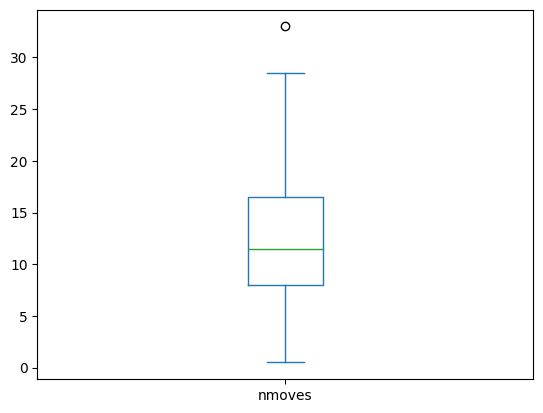

- Score 98.89% for games with only legal moves
Score 72.95% for all games i.e. 44.5/61, being legal or illegal (illegal move = loss)
- Out of 61 games, 45 were legal games and 16 were illegal games, hence 26% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| hxg8=          |       4 |
| gxh8=          |       3 |
| {[%clk         |       2 |
| bxc1=          |       1 |
| gxf8=          |       1 |
| exf8=          |       1 |
| dxc8=          |       1 |
| gxh1=          |       1 |
| cxd8=          |       1 |
| {The           |       1 |


ANALYSIS OF gpt-3.5-turbo, WITH 'random_engine == True':
- 23 total games, with lengths:


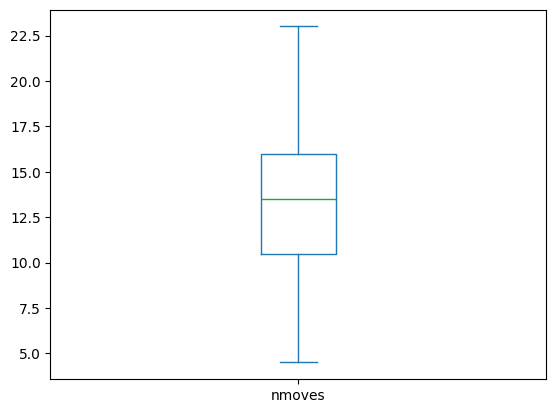

- Score 100.0% for games with only legal moves
Score 26.09% for all games i.e. 6.0/23, being legal or illegal (illegal move = loss)
- Out of 23 games, 6 were legal games and 17 were illegal games, hence 74% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| fxg6           |       1 |
| fxg8=Q         |       1 |
| cxd6           |       1 |
| Bxd6           |       1 |
| hxg8=Q         |       1 |
| dxe6           |       1 |
| exf6           |       1 |
| Bxg8           |       1 |
| Qxf8#          |       1 |
| Nf7+           |       1 |
| Qd5            |       1 |
| Nxf6#          |       1 |
| fxg7           |       1 |
| gxh8=Q         |       1 |
| Bxf8           |       1 |
| Qe2#           |       1 |
| Qxd8+          |       1 |


ANALYSIS OF gpt-4, WITH 'random_engine == True':
- 85 total games, with lengths:


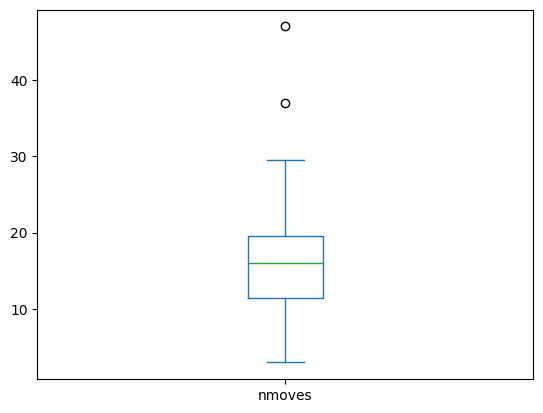

- Score 99.15% for games with only legal moves
Score 68.82% for all games i.e. 58.5/85, being legal or illegal (illegal move = loss)
- Out of 85 games, 59 were legal games and 26 were illegal games, hence 31% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| 12...          |       2 |
| exd8           |       1 |
| gxh7+          |       1 |
| Bxf8           |       1 |
| Qd4            |       1 |
| Rxg8           |       1 |
| Qh5            |       1 |
| fxg7           |       1 |
| exd2+          |       1 |
| Qd5+           |       1 |
| gxh8           |       1 |
| Qh4#           |       1 |
| Nxg4           |       1 |
| 16...          |       1 |
| 5.             |       1 |
| Bxa6           |       1 |
| Qxd8           |       1 |
| cxd8           |       1 |
| Qae8#          |       1 |
| 17...          |       1 |
| Qd7            |       1 |
| 14...          |       1 |
| Qxc8#          |       1 |
| 9...           |       1 |


In [80]:
for model_name in ("gpt-3.5-turbo-instruct", "gpt-3.5-turbo", "gpt-4"):
    illegal_moves_analysis(df_random, model_name, "random_engine == True")
    print("\n")

### GPTs against SF

In [23]:
df_non_random = df.query("random_engine == False and nstarting_move <= 2")

ANALYSIS OF gpt-3.5-turbo-instruct, WITH 'random_engine == False and nstarting_move <= 2':
- 439 total games, with lengths:


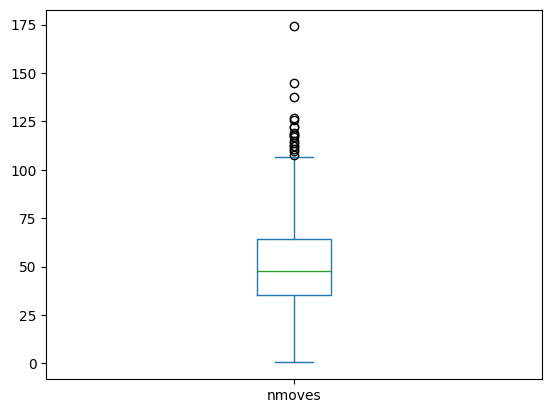

- Score 38.48% for games with only legal moves
Score 32.35% for all games i.e. 142.0/439, being legal or illegal (illegal move = loss)
- Out of 439 games, 369 were legal games and 70 were illegal games, hence 16% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| 1-0            |      49 |
| 1-             |       4 |
| axb8=          |       1 |
| dxe8=          |       1 |
| f7             |       1 |
| Kb3            |       1 |
| cxb8=          |       1 |
| gxh8=          |       1 |
| Qa7            |       1 |
| bxc3           |       1 |
| {(Leko-G       |       1 |
| {This          |       1 |
| {[%clk         |       1 |
| exf8=          |       1 |
| Rxh5           |       1 |
| Nxa3           |       1 |
| {The           |       1 |
| bxc8=          |       1 |
| {M.            |       1 |


ANALYSIS OF gpt-3.5-turbo, WITH 'random_engine == False and nstarting_move <= 2':
- 30 total games, with lengths:


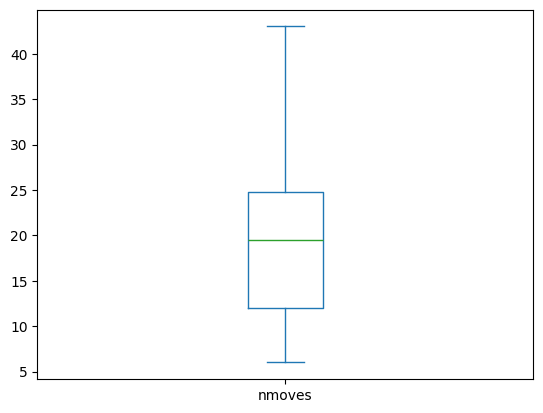

- Score 0.0% for games with only legal moves
Score 0.0% for all games i.e. 0.0/30, being legal or illegal (illegal move = loss)
- Out of 30 games, 2 were legal games and 28 were illegal games, hence 93% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| Qxe4           |       2 |
| cxb7           |       2 |
| Bg8            |       1 |
| Bxc6           |       1 |
| Rxf6           |       1 |
| Bxf6           |       1 |
| exf6           |       1 |
| Rxh1           |       1 |
| Nxe5+          |       1 |
| O-O            |       1 |
| Bh4            |       1 |
| Bxd6+          |       1 |
| Bxh6           |       1 |
| Nxf7+          |       1 |
| Qxf5           |       1 |
| c4             |       1 |
| Qxf6           |       1 |
| cxd6           |       1 |
| Rxf7+          |       1 |
| Kxe1           |       1 |
| Rxh6           |       1 |
| Rd8            |       1 |
| Qxg5           |       1 |
| Nxd1           |       1 |
| Nxe1

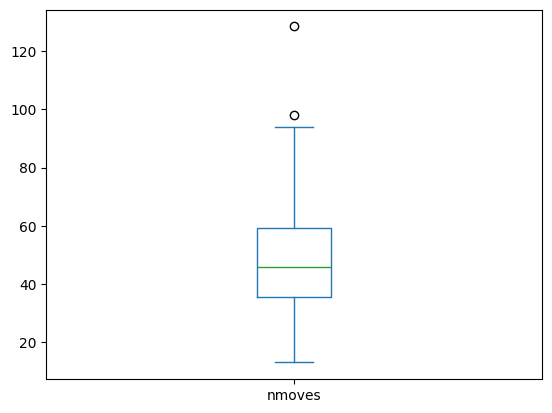

- Score 7.03% for games with only legal moves
Score 4.79% for all games i.e. 4.5/94, being legal or illegal (illegal move = loss)
- Out of 94 games, 64 were legal games and 30 were illegal games, hence 32% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| Rxe8           |       1 |
| gxh6           |       1 |
| Bb7            |       1 |
| b5             |       1 |
| Kb6            |       1 |
| Bxf7           |       1 |
| Kxd6           |       1 |
| Rxh1           |       1 |
| Checkmate!     |       1 |
| Kg3            |       1 |
| Bxf6           |       1 |
| Nxb6           |       1 |
| Kg1.           |       1 |
| Rd3            |       1 |
| Rd1+           |       1 |
| Kxb5           |       1 |
| Kd2            |       1 |
| Qxh3           |       1 |
| Kxe6           |       1 |
| Bg2            |       1 |
| Qe5+           |       1 |
| Kxf3           |       1 |
| Rd7            |       1 |
| Kxf5           |       1 |
| B

In [81]:
for model_name in ("gpt-3.5-turbo-instruct", "gpt-3.5-turbo", "gpt-4"):
    illegal_moves_analysis(df, model_name, "random_engine == False and nstarting_move <= 2")
    print("\n")

### Focus on GPT 3.5 turbo-instruct's illegal moves against SF

It appears that the vast majority on its illegal moves are "1-0", indicating that it may resign as black, probably in worse positions. We can put this hypothesis to the test by evaluating these positions with Stockfish:

In [24]:
from stockfish import Stockfish

# A list to store your data
data_list = []

illegal_moves10 = df_non_random.query("(white == 'gpt-3.5-turbo-instruct' or black == 'gpt-3.5-turbo-instruct') and illegal_move == '1-0'")

for index, row in illegal_moves10.iterrows():
    if row['white'] == 'gpt-3.5-turbo-instruct':
        color = "White"
    else:
        color = "Black"

    # read the PGN file
    with open(row['folder_name'] + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)
        board = game.board()
        for move in game.mainline_moves():
            board.push(move)

        stockfish = Stockfish("./stockfish/stockfish/stockfish-ubuntu-x86-64-avx2")
        stockfish.set_position([str(m) for m in game.mainline_moves()])
        # stockfish._go_time(5000)
        ev = stockfish.get_evaluation()

        # Create an evaluation string
        if ev['type'] == 'cp':
            evaluation = str(ev['value']/100)
        else:
            evaluation = "Mate in " + str(ev['value'])

        # Append the dictionary to your list
        data_list.append({
            "GPT Color": color,
            "Assessment": evaluation
        })

# Convert the list of dictionaries into a dataframe
df_results = pd.DataFrame(data_list)

# If you want to see the first few rows of your dataframe:
print(df_results.to_markdown())

|    | GPT Color   | Assessment   |
|---:|:------------|:-------------|
|  0 | Black       | Mate in 1    |
|  1 | Black       | Mate in 9    |
|  2 | Black       | Mate in 1    |
|  3 | Black       | 35.81        |
|  4 | Black       | 10.46        |
|  5 | Black       | 5.51         |
|  6 | Black       | 6.79         |
|  7 | Black       | 5.64         |
|  8 | Black       | 6.81         |
|  9 | Black       | -0.41        |
| 10 | Black       | -1.54        |
| 11 | Black       | 6.39         |
| 12 | Black       | 34.74        |
| 13 | Black       | 7.16         |
| 14 | Black       | 6.17         |
| 15 | Black       | Mate in 2    |
| 16 | Black       | Mate in 7    |
| 17 | Black       | 5.48         |
| 18 | Black       | 7.79         |
| 19 | Black       | 6.97         |
| 20 | Black       | Mate in 1    |
| 21 | Black       | 5.22         |
| 22 | Black       | 6.64         |
| 23 | Black       | 6.39         |
| 24 | Black       | Mate in 3    |
| 25 | Black       | 5.83   

Conclusion: Indeed, "1-0" is a correct continuation (even though it is not technically a chess move), since it means black resigns the game. Moreover, this decision is often very logical, since it occurs in positions where white is dominating.

# Elo rating of GPTs against SF

In [33]:
def parse_result(row, parse_method_if_illegal: callable):
    if row["has_illegal"] is True:
        return parse_method_if_illegal(row)
    
    result_for_white = 1 if row["result"] == "1-0" else 0 if row["result"] == "0-1" else 0.5
    if row['white_elo'] == '?':
        return result_for_white
    else:
        return 1 - result_for_white

def compute_elo_against_stockfish(df, model_name, computing_method: callable, parse_method_if_illegal:callable, filtering_rules=None):
    df = df.query(f"random_engine == False and (white == '{model_name}' or black == '{model_name}')")
    
    if filtering_rules is not None:
        print(f"ELO OF {model_name}, WITH '{filtering_rules}':")
        df = df.query(filtering_rules)
    else:
        print(f"ELO OF {model_name}:")
        
    # Prepare the dataframe for elo calculation
    new_df = pd.DataFrame()
    new_df["opponent_elo"] = df.apply(lambda row: float(row['white_elo'] if row['white_elo'] != '?' else row['black_elo']), axis=1)
    new_df["result"] = df.apply(lambda row: parse_result(row, parse_method_if_illegal), axis=1)

    elo = round(computing_method(new_df))
    print(elo)

In [34]:
def fide_perf_rating(games: pd.DataFrame):
    """
    required columns: opponent_elo and result (0 for loss, 0.5 for draw, 1 for win)
    https://en.wikipedia.org/wiki/Elo_rating_system
    """
    def lookup_fide_table(score):
        # Data here: https://handbook.fide.com/chapter/B022017
        data = {
            'p': [1.0, .99, .98, .97, .96, .95, .94, .93, .92, .91, .90, .89, .88, .87, .86, .85, .84,
                .83, .82, .81, .80, .79, .78, .77, .76, .75, .74, .73, .72, .71, .70, .69, .68, .67,
                .66, .65, .64, .63, .62, .61, .60, .59, .58, .57, .56, .55, .54, .53, .52, .51, .50,
                .49, .48, .47, .46, .45, .44, .43, .42, .41, .40, .39, .38, .37, .36, .35, .34, .33,
                .32, .31, .30, .29, .28, .27, .26, .25, .24, .23, .22, .21, .20, .19, .18, .17, .16,
                .15, .14, .13, .12, .11, .10, .09, .08, .07, .06, .05, .04, .03, .02, .01, 0.0],
            'dp': [800, 677, 589, 538, 501, 470, 444, 422, 401, 383, 366, 351, 336, 322, 309, 296, 284,
                273, 262, 251, 240, 230, 220, 211, 202, 193, 184, 175, 166, 158, 149, 141, 133, 125,
                117, 110, 102, 95, 87, 80, 72, 65, 57, 50, 43, 36, 29, 21, 14, 7, 0, -7, -14, -21, 
                -29, -36, -43, -50, -57, -65, -72, -80, -87, -95, -102, -110, -117, -125, -133, -141,
                -149, -158, -166, -175, -184, -193, -202, -211, -220, -230, -240, -251, -262, -273, 
                -284, -296, -309, -322, -336, -351, -366, -383, -401, -422, -444, -470, -501, -538, -589, -677, -800]
        }
        
        # Convert to DataFrame
        df_fide = pd.DataFrame(data)
        
        rscore = round(score, 2)
        # lookup score in table
        dp = df_fide.loc[df_fide['p'] == rscore, 'dp'].iloc[0]
        return dp
    
    elo = games["opponent_elo"].mean() + lookup_fide_table(games["result"].mean())
    return elo

In [27]:
def illegal_implies_loss(row):
    return 0

### Overall GPTs' performances

In [ ]:
def extract_elo_ratings(df_l, model_gpt_name):
    wrs = [] # winning games 
    lrs = [] # losing games
    drs = [] # drawing games
    
    # Filter and iterate over the dataframe
    for _, row in df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and `has_illegal` == False").iterrows():
        if row['white'] == model_gpt_name and row['result'] == '1-0':
            wrs.append(row['black_elo'])
        elif row['black'] == model_gpt_name and row['result'] == '0-1':
            wrs.append(row['white_elo'])
        elif row['black'] == model_gpt_name and row['result'] == '1-0':
            lrs.append(row['white_elo'])
        elif row['white'] == model_gpt_name and row['result'] == '0-1':
            lrs.append(row['black_elo'])
        elif row['result'] == '1/2-1/2':
            if row['white'] == model_gpt_name:
                drs.append(row['black_elo'])
            else:
                drs.append(row['white_elo'])
        else:
            print("warning")
            print(row)
            continue

    wrs = [float(val) for val in wrs]
    lrs = [float(val) for val in lrs]
    drs = [float(val) for val in drs]
    
    return wrs, lrs, drs

def plot_elo_distribution(wrs, lrs, drs, model_gpt_name):
    # Compute unique Elos and their counts
    unique_elos = sorted(np.unique(wrs))
    win_counts = [wrs.count(elo) for elo in unique_elos]
    draw_counts = [drs.count(elo) for elo in unique_elos]
    lose_counts = [lrs.count(elo) for elo in unique_elos]

    # Plotting
    bar_width = 0.3
    index = np.arange(len(unique_elos))
    plt.figure(figsize=(15, 5))
    plt.bar(index, win_counts, bar_width, alpha=0.7, color='green', label='Winning Games')
    plt.bar(index + bar_width, draw_counts, bar_width, alpha=0.7, color='blue', label='Drawing Games')
    plt.bar(index + 2 * bar_width, lose_counts, bar_width, alpha=0.7, color='red', label='Losing Games')

    plt.xlabel('Elo Rating')
    plt.ylabel('Number of Games')
    plt.title(f'Distribution of Elo Ratings by Game Result for {model_gpt_name}')

    plt.xticks(index + bar_width, unique_elos, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # De-comment to save this as a png image
    # plt.savefig(f"elo_distribution-scores-{model_gpt_name}.png", dpi=300, bbox_inches='tight')
    
    plt.show()

def analyze_and_plot_elo_distribution(df_l, model_gpt_name):
    wrs, lrs, drs = extract_elo_ratings(df_l, model_gpt_name)
    plot_elo_distribution(wrs, lrs, drs, model_gpt_name)

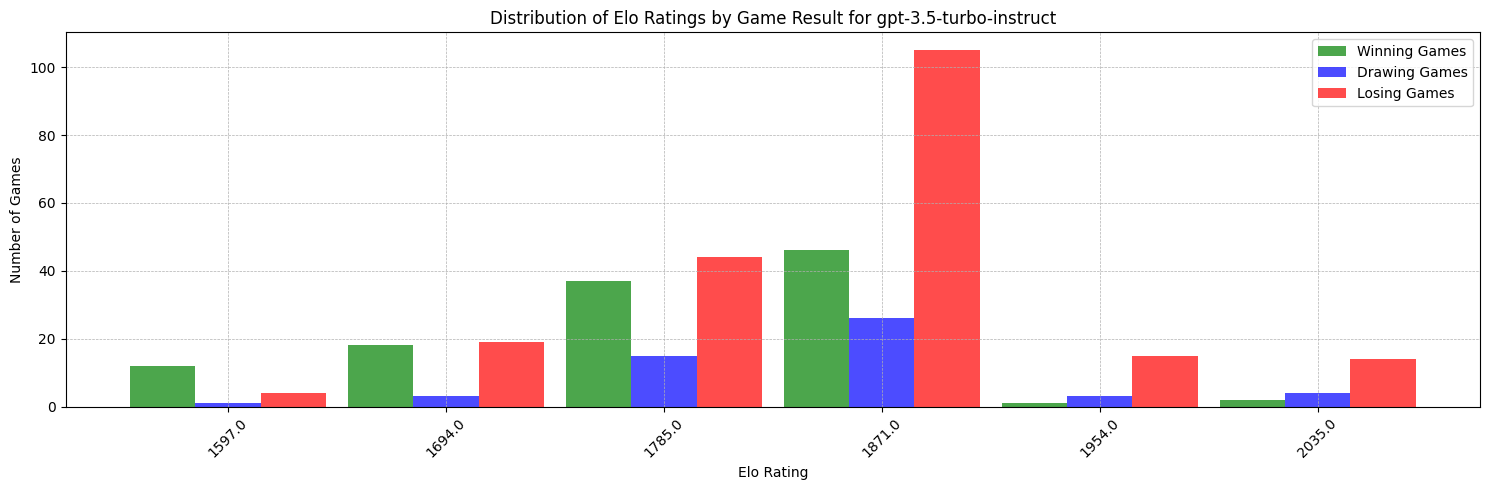

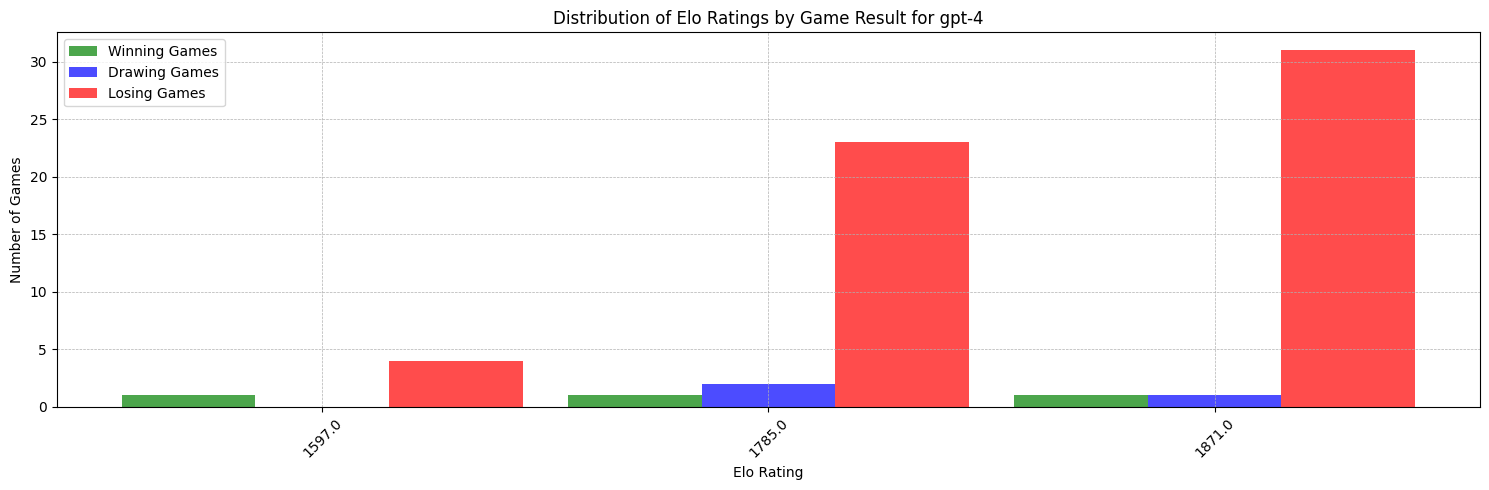

In [45]:
analyze_and_plot_elo_distribution(df_non_random, "gpt-3.5-turbo-instruct")
analyze_and_plot_elo_distribution(df_non_random, "gpt-4")

### Influence of the prompt on win rates:

- With the based prompt:

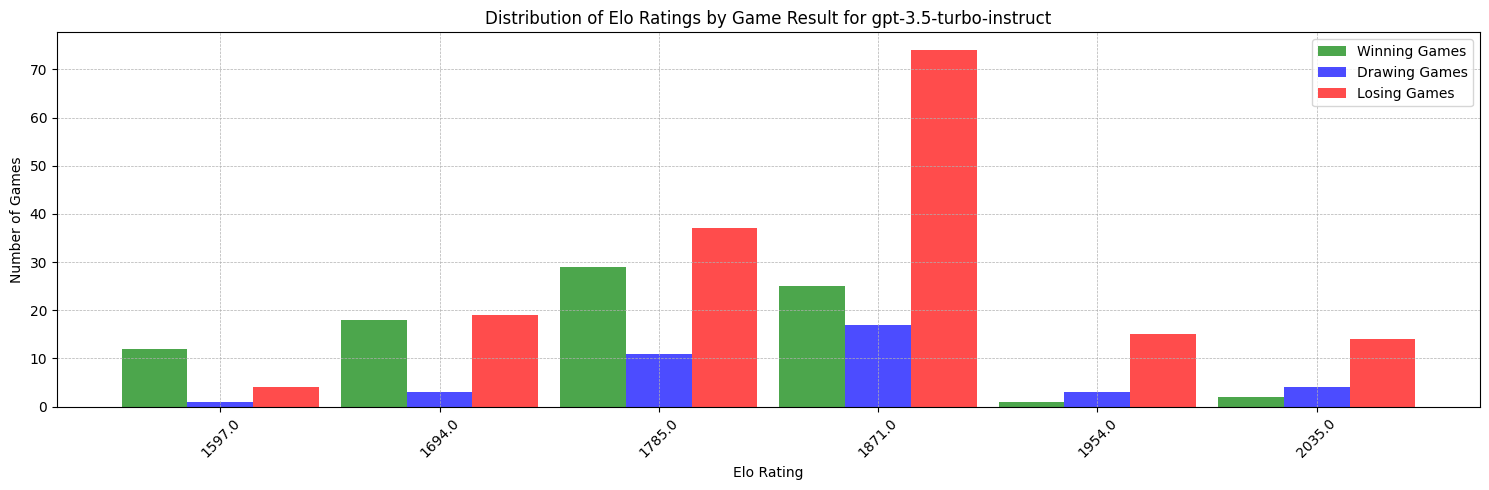

In [43]:
analyze_and_plot_elo_distribution(df_non_random.query("not pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')

- With the altered prompt:

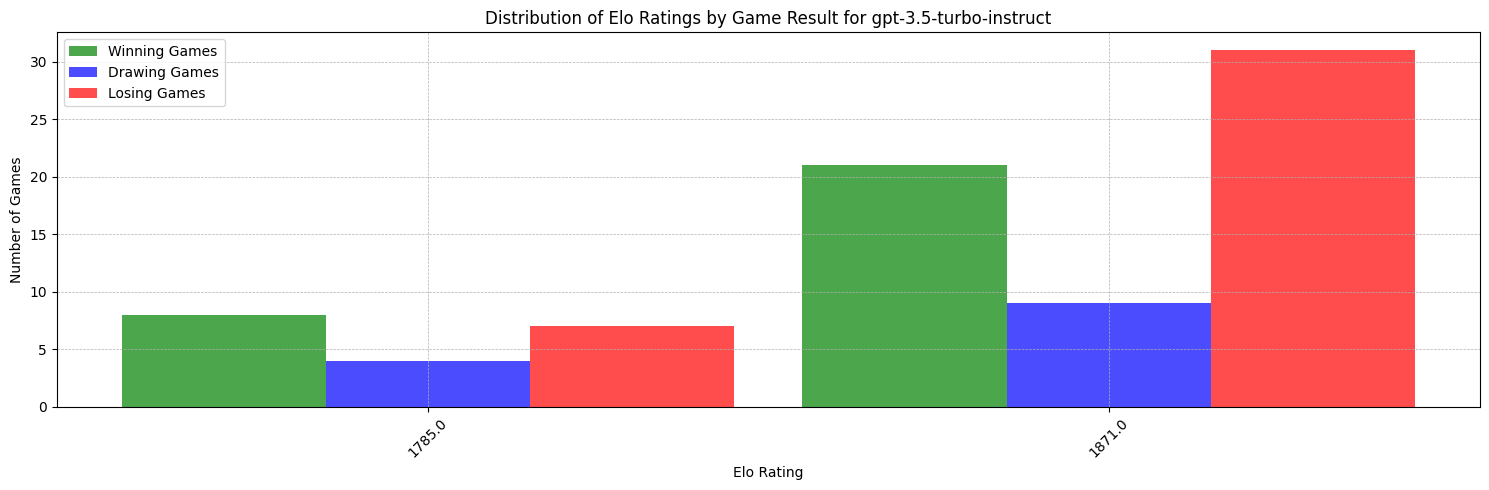

In [44]:
analyze_and_plot_elo_distribution(df_non_random.query("pgn_base.str.contains('Rennes FRA')"), 'gpt-3.5-turbo-instruct')

### GPT 3.5 turbo-instruct's elo

In [28]:
model_name = "gpt-3.5-turbo-instruct"

compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.0 and has_illegal==False")
compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.0")

compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.2 and has_illegal==False")
compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.2")

compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.8 and has_illegal==False")
compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.8")

ELO OF gpt-3.5-turbo-instruct, WITH 'nstarting_move <= 2 and temperature == 0.0 and has_illegal==False':
1789
ELO OF gpt-3.5-turbo-instruct, WITH 'nstarting_move <= 2 and temperature == 0.0':
1742
ELO OF gpt-3.5-turbo-instruct, WITH 'nstarting_move <= 2 and temperature == 0.2 and has_illegal==False':
1071
ELO OF gpt-3.5-turbo-instruct, WITH 'nstarting_move <= 2 and temperature == 0.2':
1071
ELO OF gpt-3.5-turbo-instruct, WITH 'nstarting_move <= 2 and temperature == 0.8 and has_illegal==False':
1572
ELO OF gpt-3.5-turbo-instruct, WITH 'nstarting_move <= 2 and temperature == 0.8':
1518


### GPT 3.5 turbo's elo

In [29]:
model_name = "gpt-3.5-turbo"

compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.0 and has_illegal==False")
compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.0")

ELO OF gpt-3.5-turbo, WITH 'nstarting_move <= 2 and temperature == 0.0 and has_illegal==False':
1071
ELO OF gpt-3.5-turbo, WITH 'nstarting_move <= 2 and temperature == 0.0':
988


### GPT 4's elo

In [30]:
model_name = "gpt-4"

compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.0 and has_illegal==False")
compute_elo_against_stockfish(df, model_name, fide_perf_rating, illegal_implies_loss, "nstarting_move <= 2 and temperature == 0.0")

ELO OF gpt-4, WITH 'nstarting_move <= 2 and temperature == 0.0 and has_illegal==False':
1393
ELO OF gpt-4, WITH 'nstarting_move <= 2 and temperature == 0.0':
1336


# Conclusion:

GPT 3.5 turbo-instructs shows a much better chess understanding than its pears (3.5 turbo, 4), both in terms of ELO and illegal moves. If we consider illegal games as losses, it has an ELO rating of 1742.

Due to the opacity of these models, we can only speculate as to the reasons why this happens: maybe the dataset used for its training contains more PGNs, or the fine-tuning for chat decreased this ability for GPT 3.5 turbo and GPT 4.

The altered prompt and the temperature have shown no significant difference on the model's performances.